# Preparation

1. `git clone https://github.com/yang-song/score_sde.git`

2. Install [required packages](https://github.com/yang-song/score_sde/blob/main/requirements.txt)

3. `cd` into folder `score_sde`, launch a local jupyter server and connect to colab following [these instructions](https://research.google.com/colaboratory/local-runtimes.html)

4. Download pre-trained [checkpoints](https://drive.google.com/drive/folders/1RAG8qpOTURkrqXKwdAR1d6cU9rwoQYnH?usp=sharing) and save them in the `exp` folder.

In [1]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
import os
import functools
import itertools
import jax.random as random

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io
import inspect
sns.set(font_scale=2)
sns.set(style="whitegrid")

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import run_lib

import sampling
import losses as losses_lib
import utils
import evaluation
from models import up_or_down_sampling as stylegan_layers
import datasets
from models import wideresnet_noise_conditional
import sde_lib
import likelihood
import controllable_generation

from sampling import *
from sde_lib import *
from scipy import integrate

import jax

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
# jax.config.update('jax_disable_jit', True)
# jax.config.update('jax_platform_name', 'cpu')

/home/jakiw/Programs/miniconda3/envs/score_sde/lib/python3.8/site-packages/flax/nn/__init__.py:35: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)
/home/jakiw/Programs/miniconda3/envs/score_sde/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# @title Load the score-based model
sde = 'VPSDE' #@param ['VESDE', 'VPSDE', 'subVPSDE'] {"type": "string"}
if sde.lower() == 'vesde':
  from configs.ve import cifar10_ncsnpp_continuous as configs
  ckpt_filename = "exp/ve/cifar10_ncsnpp_continuous/checkpoint_24"
  config = configs.get_config()  
  sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
  sampling_eps = 1e-5
elif sde.lower() == 'vpsde':
  from configs.vp import cifar10_ddpmpp_continuous as configs
  ckpt_filename = "exp/vp/cifar10_ddpmpp_continuous/checkpoint_8"  
  config = configs.get_config()
  sde = VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
  sampling_eps = 1e-3
elif sde.lower() == 'subvpsde':
  from configs.subvp import cifar10_ddpmpp_continuous as configs
  ckpt_filename = "exp/subvp/cifar10_ddpmpp_continuous/checkpoint_26"
  config = configs.get_config()
  sde = subVPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
  sampling_eps = 1e-3

batch_size =   1#@param {"type":"integer"}
local_batch_size = batch_size // jax.local_device_count()
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}
rng = jax.random.PRNGKey(random_seed)
rng, run_rng = jax.random.split(rng)
rng, model_rng = jax.random.split(rng)
score_model, init_model_state, initial_params = mutils.init_model(run_rng, config)
optimizer = losses_lib.get_optimizer(config).create(initial_params)

state = mutils.State(step=0, optimizer=optimizer, lr=config.optim.lr,
                      model_state=init_model_state,
                      ema_rate=config.model.ema_rate,
                      params_ema=initial_params,
                      rng=rng)  # pytype: disable=wrong-keyword-args
sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
state = utils.load_training_state(ckpt_filename, state)

In [3]:
#@title Visualization code

def image_grid(x):
    size = config.data.image_size
    channels = config.data.num_channels
    img = x.reshape(-1, size, size, channels)
    w = int(np.sqrt(img.shape[0]))
    img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
    return img

def show_samples(x):
    img = image_grid(x)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(img)
    plt.show()


# Predictor-Corrector sampling

Default settings:

 | dataset | SDE | predictor | corrector | snr | n_steps |
|:----:|:----:|:----------:|:--------:|:---:|:----:|
|CIFAR-10 | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.16| 1|
|CIFAR-10 | VP | EulerMaruyamaPredictor | None | - | - |
|CIFAR-10 | subVP| EulerMaruyamaPredictor | None | - | - |
| LSUN/CelebA-HQ/FFHQ 256px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.075 | 1 |
| FFHQ 1024px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.15| 1 |

Check `probability_flow` to run PC sampling based on discretizing the probability flow ODE.

In [4]:
dataset_builder = tfds.builder('cifar10')
train_split_name = 'train'
eval_split_name = 'test'
dataset_options = tf.data.Options()
read_config = tfds.ReadConfig(options=dataset_options)
dataset_builder.download_and_prepare()
ds = dataset_builder.as_dataset(split=train_split_name, shuffle_files=False, read_config=read_config)
train_ds_np = jnp.array(np.stack(i["image"] for i in ds)) / 255

/home/jakiw/Programs/miniconda3/envs/score_sde/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [5]:
# train_ds, test_ds = tfds.load('cifar10', split=['train','test'], as_supervised=True)

# train_ds_np = jnp.array(np.stack([list(map(lambda i: i[0], tfds.as_numpy(train_ds)))]))

In [6]:
# def true_score(x, t):
#     log_mean_coeff = -0.25 * t ** 2 * (beta_1 - beta_0) - 0.5 * t * beta_0
#     var = 1 - jnp.exp(2. * log_mean_coeff)
#     return np.mean(-(x - train_ds_np * jnp.exp(log_mean_coeff))/var, axis=0)

beta_1 = config.model.beta_max
beta_0 = config.model.beta_min
def log_marginal(x, t):
    J = 1000
    used_data = train_ds_np[:J, :, :, :]
    log_mean_coeff = -0.25 * t ** 2 * (beta_1 - beta_0) - 0.5 * t * beta_0
    mean_coeff = jnp.exp(log_mean_coeff)
    var = 1 - jnp.exp(2. * log_mean_coeff)
    distances = jnp.sum(((x - mean_coeff * used_data)**2).reshape(J, -1), axis=1)
    return jax.scipy.special.logsumexp(-distances/(2*var), b=1/J)
    
true_score = jax.jit(jax.grad(log_marginal))

In [7]:
def distance_to_cifar(x):
    d = jnp.sqrt(jnp.min(jnp.sum(((x - train_ds_np)**2).reshape(train_ds_np.shape[0], -1), axis=1)))
    return d

In [8]:
#variables = {'params': state.params_ema, **state.model_state}
# def trained_score(x, t):
#     times = jnp.array([t])
#     std = sde.marginal_prob(x, times)[1]
#     times_model = times * 999
#     return -score_model.apply(variables, x, times_model, train=False, mutable=False)/std
trained_score = mutils.get_score_fn(sde, score_model, state.params_ema, state.model_state, train=False, continuous=True)
trained_score2 = mutils.get_score_fn(sde, score_model, state.params_ema, state.model_state, train=False, continuous=True)


In [10]:
from jax.experimental.host_callback import id_print
eps = 1e-3
N = 1000
timesteps = jnp.linspace(sde.T, eps, sde.N)
rsde = sde.reverse(true_score, False)
dt = 1. / N
shape = (1, 32, 32, 3)


def sample_with_true_score(rng):
    def loop_body(i, val):
        rng, x, x_mean, y, y_mean, distances = val
        t = timesteps[i]
        vec_t = jnp.ones(shape[0]) * t
        beta_t = beta_0 + t * (beta_1 - beta_0)
        diffusion = jnp.sqrt(beta_t)
        
        drift = -0.5 * beta_t * x
        score = trained_score(x, vec_t)
        drift = drift - diffusion**2 *  score
        rng, step_rng = random.split(rng)
        z = random.normal(step_rng, x.shape)
        x_mean = x - drift * dt
        x = x_mean + diffusion * jnp.sqrt(dt) * z
        
        drift = -0.5 * beta_t * y
        score = true_score(y, vec_t)
        drift = drift - diffusion**2 *  score
        #rng, step_rng = random.split(rng)
        #z = random.normal(step_rng, y.shape)
        y_mean = y - drift * dt
        y = y_mean + diffusion * jnp.sqrt(dt) * z
        
        d_x = distance_to_cifar(x)
        d_y = distance_to_cifar(y)
        distances = distances.at[i, :].set([d_x, d_y])
        return rng, x, x_mean, y, y_mean, distances

    _rng, rng = jax.random.split(rng, jax.local_device_count() + 1)
    rng, step_rng = random.split(rng)
    x = jnp.zeros(shape)#sde.prior_sampling(step_rng, shape)
    distances = jnp.zeros((N, 2))
    
    #sde.N
    _, x, x_mean, y, y_mean, distances = jax.lax.fori_loop(0, N, loop_body, (rng, x, x, x, x, distances))
    return inverse_scaler(x_mean), inverse_scaler(y_mean), distances

In [11]:
random_seed = 36 #@param {"type": "integer"}
rng = jax.random.PRNGKey(random_seed)
N_trials = 5
dists = []
for i in range(N_trials):
    rng, step_rng = random.split(rng)
    _x, _y, d = sample_with_true_score(step_rng)
    dists.append(d)
dists = jnp.stack(dists)

In [34]:
from jax.experimental.host_callback import id_print
eps = 1e-3
N = 1000
timesteps = jnp.linspace(sde.T, eps, sde.N)
rsde = sde.reverse(true_score, False)
dt = 1. / N
shape = (1, 32, 32, 3)


def sample_with_true_score(rng):
    def loop_body(i, val):
        rng, x, x_mean, log_girsanov_weights = val
        t = timesteps[i]
        vec_t = jnp.ones(shape[0]) * t
        beta_t = beta_0 + t * (beta_1 - beta_0)
        diffusion = jnp.sqrt(beta_t)
        
        drift = -0.5 * beta_t * x
        score = trained_score(x, vec_t)
        
        score_true = true_score(x, vec_t)
    
        
        z = random.normal(step_rng, x.shape)
        x_mean = x - drift * dt
        x = x_mean + diffusion * jnp.sqrt(dt) * z
    
        err = np.sqrt(dt)* diffusion * np.sum((score_true - score) * z) - dt * 0.5 * diffusion**2 * np.sum((score_true - score)**2)
        log_girsanov_weights = log_girsanov_weights.at[i+1].set(log_girsanov_weights[i] + err)
        
        return rng, x, x_mean, log_girsanov_weights

    _rng, rng = jax.random.split(rng, jax.local_device_count() + 1)
    rng, step_rng = random.split(rng)
    sde.prior_sampling(step_rng, shape)
    log_girsanov_weights = np.zeros(N+1)
    x = sde.prior_sampling(step_rng, shape)

    #sde.N
    _, x, x_mean, log_girsanov_weights = jax.lax.fori_loop(0, sde.N, loop_body, (rng, x, x, log_girsanov_weights))
    return inverse_scaler(x_mean), log_girsanov_weights

In [35]:
random_seed = 36 #@param {"type": "integer"}
rng = jax.random.PRNGKey(random_seed)
sample, weights = sample_with_true_score(rng)

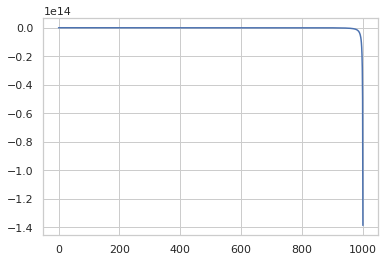

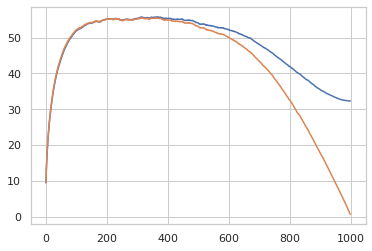

In [99]:
plt.plot(mdists[:, 0])
plt.plot(mdists[:, 1])

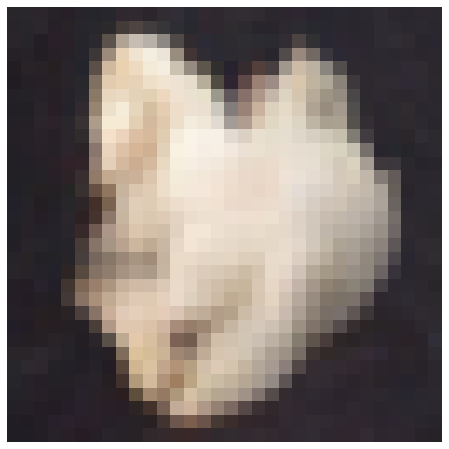

In [60]:
show_samples(x)

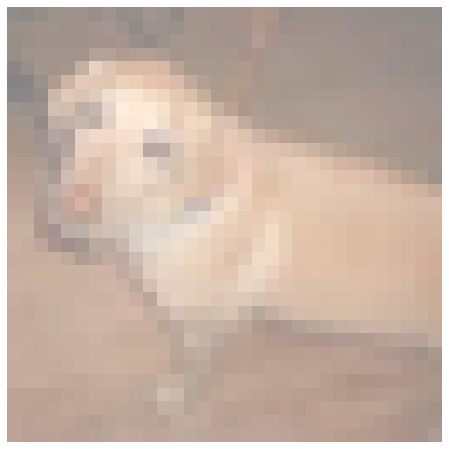

In [46]:
show_samples(y)

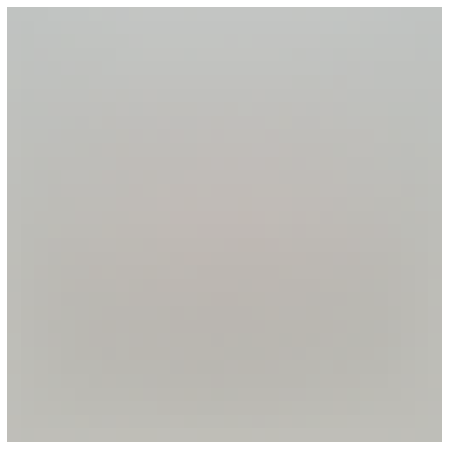

In [25]:
show_samples(y)

In [151]:
y

DeviceArray([[[[ 1.2800488 ,  1.0624657 ,  0.743801  ],
               [ 0.63257766,  0.5625065 ,  0.39141965],
               [ 0.24296531,  0.42075446,  0.92586565],
               ...,
               [-0.01695329, -0.1982243 ,  0.8939581 ],
               [ 0.4282928 ,  0.7860764 , -0.14051127],
               [ 0.09600842,  0.686167  ,  1.6710567 ]],

              [[ 0.4472619 , -0.3101666 ,  0.42172176],
               [ 0.20458174,  1.3668654 ,  0.26953655],
               [ 0.75237644,  0.6684037 , -0.07418704],
               ...,
               [ 1.5829313 ,  0.83408606,  1.6638955 ],
               [ 0.1715877 ,  1.1069641 ,  0.28713703],
               [ 0.68714714,  0.52283   ,  0.25009197]],

              [[ 1.0330669 ,  0.55909896,  0.68353206],
               [-0.5053791 ,  0.6503389 , -0.02771503],
               [ 0.3634498 , -0.05141485,  0.00345901],
               ...,
               [ 0.11303484,  0.71970177,  0.99151784],
               [ 1.1441679 ,  0.71056783

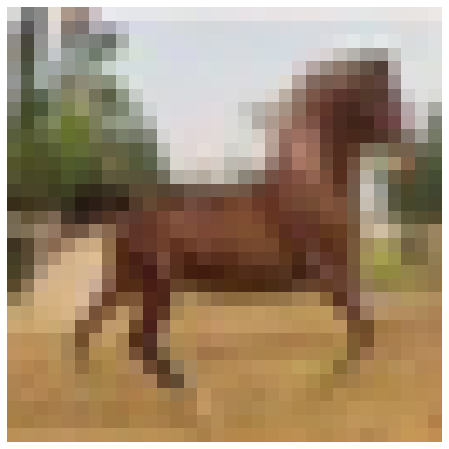

In [16]:
#@title PC sampling
random_seed = 15 #@param {"type": "integer"}
rng = jax.random.PRNGKey(random_seed)
img_size = config.data.image_size
channels = config.data.num_channels
shape = (local_batch_size, img_size, img_size, channels)
predictor = EulerMaruyamaPredictor #ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = None #LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
# predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
# corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}

snr = 0.16 #@param {"type": "number"}
n_steps =  1#@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
n_steps = 0
sampling_fn = sampling.get_pc_sampler(sde, score_model, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps)


rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
step_rng = jnp.asarray(step_rng)
pstate = flax.jax_utils.replicate(state)
x, n, rng = sampling_fn(step_rng, pstate)
show_samples(x)
# print(x.flatten()[0:5])

In [ ]:
# score_fn = mutils.get_score_fn(sde, score_model, state.params_ema, state.model_state, train=False, continuous=True)
# rsde = sde.reverse(score_fn, False)
# dt = -1. / rsde.N
# drift, diffusion = rsde.sde(x, vec_t)

In [167]:
rng = jax.random.PRNGKey(random_seed)
timesteps = jnp.linspace(sde.T, sampling_eps, sde.N)

#this is done in the original code to split over the number of devices
_rng, rng = jax.random.split(rng, jax.local_device_count() + 1)

rng, step_rng = random.split(rng)
x = sde.prior_sampling(step_rng, shape)

t = timesteps[0]
vec_t = jnp.ones(shape[0]) * t
#corrector rng which is not used
rng, step_rng = random.split(rng)
rng, step_rng = random.split(rng)


beta_t = beta_0 + t * (beta_1 - beta_0)
drift = -0.5 * beta_t * x
diffusion = jnp.sqrt(beta_t)
# print(jnp.expand_dims(x, 0).shape)

score = trained_score(jnp.expand_dims(x, 0), t)
drift = drift - diffusion**2 *  score

z = random.normal(step_rng, x.shape)
x_mean = x + drift * dt
x = x_mean + diffusion * jnp.sqrt(-dt) * z




[ 1.4682175   1.2456753  -0.6192946  -0.96930355 -0.28311   ]
[999.]
[0.99997836]
[-1.4650129  -1.2407392   0.6186844   0.96768963  0.2828456 ]


In [ ]:
[ 1.4682175   1.2456753  -0.6192946  -0.96930355 -0.28311   ]
[999.]
[0.99997836]
[-1.4650129  -1.2407395   0.6186845   0.9676895   0.28284562]

In [139]:
[ 1.4682175   1.2456753  -0.6192946  -0.96930355 -0.28311   ]
[999.]
[0.99997836]
[-1.465013   -1.2407395   0.6186844   0.96768945  0.2828456 ]

DeviceArray([ 1.1418042 ,  0.7436417 ,  0.6336486 ,  1.5564859 ,
              0.98108965,  1.5775076 ,  1.2088844 , -0.23382626,
              1.3517703 , -0.9047096 ], dtype=float32)

DeviceArray([ 1.1418042 ,  0.7436417 ,  0.6336486 ,  1.5564859 ,
              0.98108965,  1.5775076 ,  1.2088844 , -0.23382626,
              1.3517703 , -0.9047096 ], dtype=float32)

In [93]:
t = timesteps[1]
vec_t = jnp.ones(shape[0]) * t
#corrector rng which is not used
rng, step_rng = random.split(rng)
rng, step_rng = random.split(rng)

#score_fn = mutils.get_score_fn(sde, score_model, state.params_ema, state.model_state, train=False, continuous=True)
#rsde = sde.reverse(score_fn, False)
#dt = -1. / rsde.N
z = random.normal(step_rng, x.shape)
drift, diffusion = rsde.sde(x, vec_t)
# print("\n\n")
# print(dt)
# print(z.flatten()[0:2])
# print(drift.flatten()[0:2])
# print(diffusion)
x_mean = x + drift * dt
x = x_mean + batch_mul(diffusion, jnp.sqrt(-dt) * z)
print()

[[[[  0.9062365    1.5946451    1.4408641 ]
   [  0.08565995  -2.8218224    2.107394  ]
   [  4.338884     0.68810964  -2.1309443 ]
   ...
   [  1.0441291    3.1470363    0.9650104 ]
   [ -0.5443522    2.7876034   -2.2978683 ]
   [  3.9687579   -2.6562989    2.3798933 ]]

  [[  1.7259736   -1.7097414   -0.96628344]
   [ -2.9298568    7.3752656   -3.394428  ]
   [  0.01828486   2.710451    -1.9893618 ]
   ...
   [ -0.79519475   1.319427    -5.1715426 ]
   [  1.6390387   -6.0870647   10.789664  ]
   [  0.53482217   2.0154421   -3.2139301 ]]

  [[  1.6066418    1.1083767    1.1853864 ]
   [  2.9990892   -6.7884803    3.697492  ]
   [ -2.969767     3.597034     6.204101  ]
   ...
   [  1.1753098    1.979099    -0.6614866 ]
   [ -0.979694     2.5886343   -2.6537802 ]
   [ -0.6764288    4.878603     0.27032906]]

  ...

  [[  2.4667907    2.1972995   -0.846679  ]
   [  3.333314    -1.0212988   -1.9597776 ]
   [ -1.9779577    2.5038416    5.666067  ]
   ...
   [  2.0001693   -3.5821877    1.2

In [47]:
timesteps

DeviceArray([1.   , 0.001], dtype=float32)

In [ ]:
#@title PC inpainting
train_ds, eval_ds, _ = datasets.get_dataset(config)
eval_iter = iter(eval_ds)
bpds = []

random_seed = 0 #@param {"type": "integer"}
rng = jax.random.PRNGKey(random_seed)

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = AnnealedLangevinDynamics #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}

pc_inpainter = controllable_generation.get_pc_inpainter(sde, score_model,
                                                        predictor, corrector,
                                                        inverse_scaler,
                                                        snr=snr,
                                                        n_steps=n_steps,
                                                        probability_flow=probability_flow,
                                                        continuous=config.training.continuous,
                                                        denoise=True)
batch = next(eval_iter)
img = batch['image']._numpy()
show_samples(img)
rng, step_rng = jax.random.split(rng)  
img = scaler(img)
mask = np.ones(img.shape)
mask[..., :, 16:, :] = 0.
mask = jnp.asarray(mask)
show_samples(inverse_scaler(img * mask))

rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
step_rng = jnp.asarray(step_rng)
pstate = flax.jax_utils.replicate(state)
x = pc_inpainter(step_rng, pstate, img, mask)
show_samples(x)

# Probability flow ODE

With black-box ODE solvers, we can produce samples, compute likelihoods, and obtain a uniquely identifiable encoding of any data point.

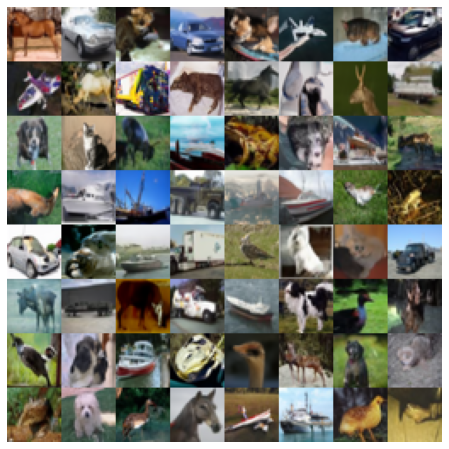

In [ ]:
 #@title ODE sampling
random_seed = 0 #@param {"type": "integer"}
rng = jax.random.PRNGKey(random_seed)

shape = (local_batch_size, 32, 32, 3)
sampling_fn = sampling.get_ode_sampler(sde, 
                                       score_model, 
                                       shape, 
                                       inverse_scaler,                                       
                                       denoise=True, 
                                       eps=sampling_eps)
rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
step_rng = jnp.asarray(step_rng)
pstate = flax.jax_utils.replicate(state)
x, nfe = sampling_fn(step_rng, pstate)
show_samples(x)

In [ ]:
#@title Likelihood computation

train_ds, eval_ds, _ = datasets.get_dataset(config, uniform_dequantization=True, evaluation=True)
eval_iter = iter(eval_ds)
bpds = []
likelihood_fn = likelihood.get_likelihood_fn(sde, 
                                             score_model, 
                                             inverse_scaler,                                             
                                             eps=1e-5)
pstate = flax.jax_utils.replicate(state)
random_seed = 0 #@param {"type": "integer"}
rng = jax.random.PRNGKey(random_seed)
for batch in eval_iter:
  img = batch['image']._numpy()
  rng, step_rng = jax.random.split(rng)    
  img = scaler(img)
  rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
  step_rng = jnp.asarray(step_rng)
  bpd, z, nfe = likelihood_fn(step_rng, pstate, img)
  bpds.extend(bpd)
  print(f"average bpd: {jnp.array(bpds).mean()}, NFE: {nfe}")

Text(0.5, 1.0, 'Reconstructed images')

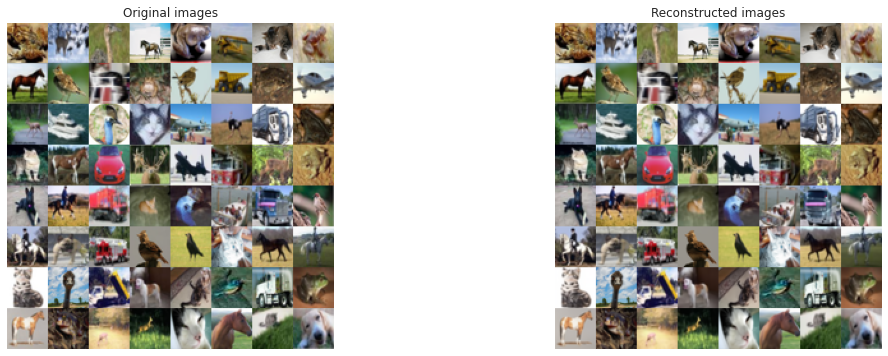

In [ ]:
#@title Representations
train_ds, eval_ds, _ = datasets.get_dataset(config, uniform_dequantization=False, evaluation=True)
eval_batch = next(iter(eval_ds))
eval_images = eval_batch['image']._numpy()
random_seed = 0 #@param {'type': 'integer'}
rng = jax.random.PRNGKey(random_seed)
shape = (local_batch_size, 32, 32, 3)

pstate = flax.jax_utils.replicate(state)
likelihood_fn = likelihood.get_likelihood_fn(sde, score_model, inverse_scaler, eps=1e-5)
sampling_fn = sampling.get_ode_sampler(sde, score_model, shape, inverse_scaler,
                                       denoise=True, eps=sampling_eps)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(image_grid(eval_images))
plt.title('Original images')

rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
step_rng = jnp.asarray(step_rng)
_, latent_z, _ = likelihood_fn(step_rng, pstate, scaler(eval_images))

rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
step_rng = jnp.asarray(step_rng)
x, nfe = sampling_fn(step_rng, pstate, latent_z)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(image_grid(x))
plt.title('Reconstructed images')

# Controllable generation

Several demonstrations on how to solve inverse problems with our SDE framework.

Default settings

 | dataset | SDE | predictor | corrector | snr | n_steps |
|:----:|:----:|:----------:|:--------:|:---:|:----:|
|CIFAR-10 | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.16| 1|
|CIFAR-10 | VP | EulerMaruyamaPredictor | None | - | - |
|CIFAR-10 | subVP| EulerMaruyamaPredictor | None | - | - |
| LSUN/CelebA-HQ/FFHQ 256px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.075 | 1 |
| FFHQ 1024px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.15| 1 |

<TakeDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                                                                                         | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]/home/jakiw/Programs/miniconda3/envs/score_sde/lib/python3.8/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.cs.toronto.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
Dl Size...:   0%|                                                                                                            | 0/162 [00:01<?, ? MiB/s]

Extraction completed...: 0 file [00:01, ? file/s]
Dl Size...:   1%|▌                                                                                                   | 1/162 [00:02<05:

Dl Size...:  29%|████████████████████████████▋                                                                      | 47/162 [00:04<00:04, 23.06 MiB/s]

Extraction completed...: 0 file [00:04, ? file/s]
Dl Size...:  30%|█████████████████████████████▎                                                                     | 48/162 [00:04<00:04, 23.39 MiB/s]

Dl Size...:  30%|█████████████████████████████▉                                                                     | 49/162 [00:04<00:04, 23.39 MiB/s]

Dl Size...:  31%|██████████████████████████████▌                                                                    | 50/162 [00:04<00:04, 23.39 MiB/s]

Extraction completed...: 0 file [00:04, ? file/s]
Dl Size...:  31%|███████████████████████████████▏                                                                   | 51/162 [00:04<00:04, 23.26 MiB/s]

Dl Size...:  32%|███████████████████████████████▊                                                                   | 52/162 [00:04<00:

Dl Size...:  60%|███████████████████████████████████████████████████████████▎                                       | 97/162 [00:06<00:02, 23.32 MiB/s]

Dl Size...:  60%|███████████████████████████████████████████████████████████▉                                       | 98/162 [00:06<00:02, 23.32 MiB/s]

Extraction completed...: 0 file [00:06, ? file/s]
Dl Size...:  61%|████████████████████████████████████████████████████████████▌                                      | 99/162 [00:06<00:02, 23.25 MiB/s]

Dl Size...:  62%|████████████████████████████████████████████████████████████▍                                     | 100/162 [00:06<00:02, 23.25 MiB/s]

Dl Size...:  62%|█████████████████████████████████████████████████████████████                                     | 101/162 [00:06<00:02, 23.25 MiB/s]

Extraction completed...: 0 file [00:06, ? file/s]
Dl Size...:  63%|█████████████████████████████████████████████████████████████▋                                    | 102/162 [00:06<00:

Extraction completed...: 0 file [00:08, ? file/s]
Dl Size...:  91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 147/162 [00:08<00:00, 23.86 MiB/s]

Dl Size...:  91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 148/162 [00:08<00:00, 23.86 MiB/s]

Dl Size...:  92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 149/162 [00:08<00:00, 23.86 MiB/s]

Extraction completed...: 0 file [00:08, ? file/s]
Dl Size...:  93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 150/162 [00:08<00:00, 23.69 MiB/s]

Dl Size...:  93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 151/162 [00:08<00:00, 23.69 MiB/s]

Dl Size...:  94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 152/162 [00:08<00:

Shuffling and writing examples to /home/jakiw/tensorflow_datasets/cifar10/3.0.2.incompleteHFPVMF/cifar10-train.tfrecord


Shuffling and writing examples to /home/jakiw/tensorflow_datasets/cifar10/3.0.2.incompleteHFPVMF/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /home/jakiw/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


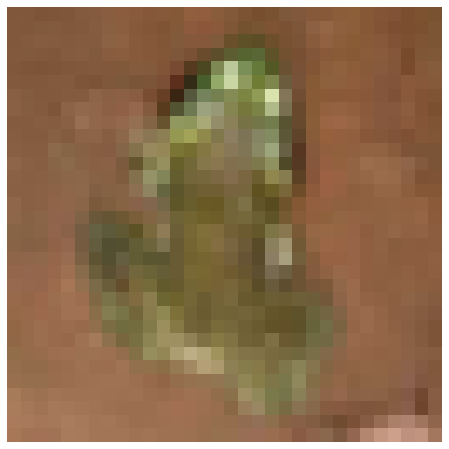

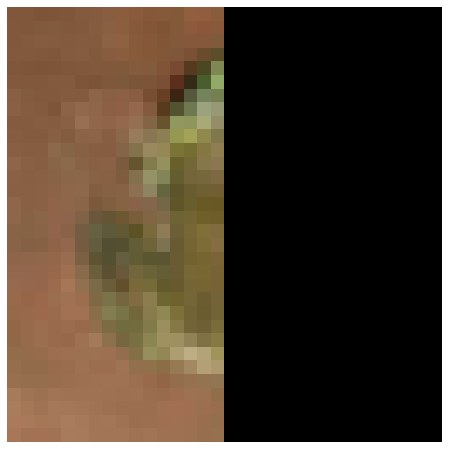

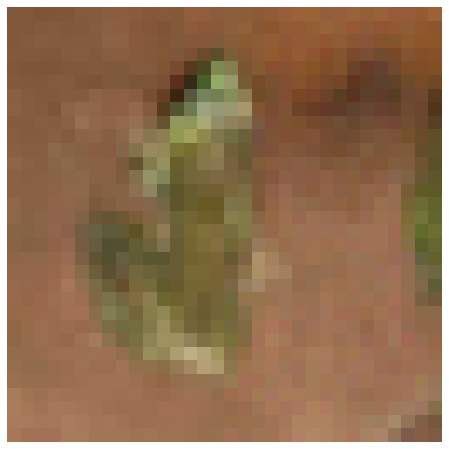

In [10]:
#@title PC inpainting
train_ds, eval_ds, _ = datasets.get_dataset(config)
eval_iter = iter(eval_ds)
bpds = []

random_seed = 0 #@param {"type": "integer"}
rng = jax.random.PRNGKey(random_seed)

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = AnnealedLangevinDynamics #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}

pc_inpainter = controllable_generation.get_pc_inpainter(sde, score_model,
                                                        predictor, corrector,
                                                        inverse_scaler,
                                                        snr=snr,
                                                        n_steps=n_steps,
                                                        probability_flow=probability_flow,
                                                        continuous=config.training.continuous,
                                                        denoise=True)
batch = next(eval_iter)
img = batch['image']._numpy()
show_samples(img)
rng, step_rng = jax.random.split(rng)  
img = scaler(img)
mask = np.ones(img.shape)
mask[..., :, 16:, :] = 0.
mask = jnp.asarray(mask)
show_samples(inverse_scaler(img * mask))

rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
step_rng = jnp.asarray(step_rng)
pstate = flax.jax_utils.replicate(state)
x = pc_inpainter(step_rng, pstate, img, mask)
show_samples(x)

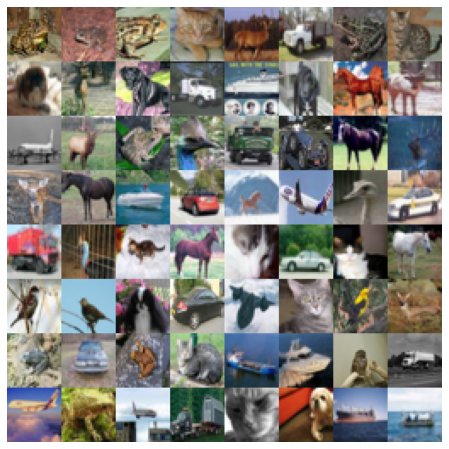

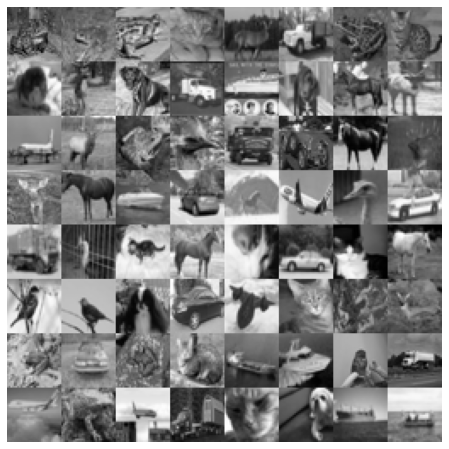

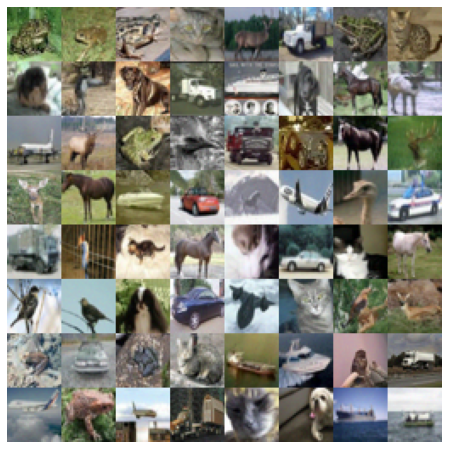

In [ ]:
#@title PC colorizer
train_ds, eval_ds, _ = datasets.get_dataset(config)
eval_iter = iter(eval_ds)
bpds = []

random_seed = 0 #@param {"type": "integer"}
rng = jax.random.PRNGKey(random_seed)

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}

batch = next(eval_iter)
img = batch['image']._numpy()
show_samples(img)
rng, step_rng = jax.random.split(rng)  
gray_scale_img = np.repeat(np.mean(img, axis=-1, keepdims=True), 3, -1)
show_samples(gray_scale_img)
gray_scale_img = scaler(gray_scale_img)
pc_colorizer = controllable_generation.get_pc_colorizer(
    sde, score_model, predictor, corrector, inverse_scaler,
    snr=snr, n_steps=n_steps, probability_flow=probability_flow,
    continuous=config.training.continuous, denoise=True
)
rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
step_rng = jnp.asarray(step_rng)
pstate = flax.jax_utils.replicate(state)
x = pc_colorizer(step_rng, pstate, gray_scale_img)

show_samples(x)

## Class-conditional generation

The classifier checkpoint can be downloaded from this [Google drive](https://drive.google.com/drive/folders/1FFPJMjENYSN-1CX_Ma-o1MTRz7gZ85N5?usp=sharing). Save it to folder `exp/classifier/wideresnet_noise_conditional`.

In [ ]:
#@title Load the noise-conditional classifier

ckpt_path = "exp/classifier/wideresnet_noise_conditional/" #@param {"type": "string"}
classifier, classifier_params = mutils.create_classifier(rng, batch_size, ckpt_path)

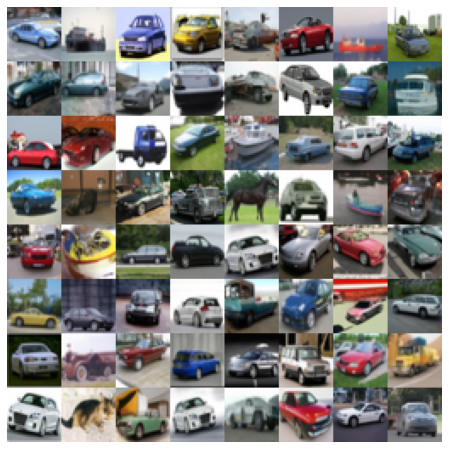

In [ ]:
#@title PC conditional sampling
random_seed = 0 #@param {"type": "integer"}
rng = jax.random.PRNGKey(random_seed)
shape = (local_batch_size, 32, 32, 3)
label = 1 #@param {"type":"integer"}
labels = jnp.ones((jax.local_device_count(), shape[0]), dtype=jnp.int32) * label
predictor = ReverseDiffusionPredictor #@param ["NonePredictor", "EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor"] {"type": "raw"}
corrector = LangevinCorrector #@param ["NoneCorrector", "LangevinCorrector", "AnnealedLangevinDynamics"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps =  2#@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
pc_conditional_sampler = controllable_generation.get_pc_conditional_sampler(
                           sde, score_model, classifier, classifier_params,
                           shape, predictor, corrector, inverse_scaler, 
                           snr, n_steps=n_steps, 
                           probability_flow=probability_flow, 
                           continuous=config.training.continuous)
rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
step_rng = jnp.asarray(step_rng)
pstate = flax.jax_utils.replicate(state)
x = pc_conditional_sampler(step_rng, pstate, labels)
show_samples(x)